In [2]:
%matplotlib inline

import pickle, gzip
import numpy as np

import random

import matplotlib.pyplot as plt

# MNIST DataSet
([mnist.pkl.gz](http://deeplearning.net/data/mnist/mnist.pkl.gz))

The MNIST dataset consists of handwritten digit images and it is divided in 60,000 examples for the training set and 10,000 examples for testing. In many papers as well as in this tutorial, the official training set of 60,000 is divided into an actual training set of 50,000 examples and 10,000 validation examples (for selecting hyper-parameters like learning rate and size of the model). All digit images have been size-normalized and centered in a fixed size image of 28 x 28 pixels. In the original dataset each pixel of the image is represented by a value between 0 and 255, where 0 is black, 255 is white and anything in between is a different shade of grey.

Here are some examples of MNIST digits:
<div align="center">
<a><img style="float:left;" alt="0" src="http://www.deeplearning.net/tutorial/_images/mnist_0.png" ></a>
<a><img style="float:left;" alt="1" src="http://www.deeplearning.net/tutorial/_images/mnist_1.png" ></a>
<a><img style="float:left;" alt="2" src="http://www.deeplearning.net/tutorial/_images/mnist_2.png" ></a>
<a><img style="float:left;" alt="3" src="http://www.deeplearning.net/tutorial/_images/mnist_3.png" ></a>
<a><img style="float:left;" alt="4" src="http://www.deeplearning.net/tutorial/_images/mnist_4.png" ></a>
<a><img style="float:left;" alt="5" src="http://www.deeplearning.net/tutorial/_images/mnist_5.png"></a>
</div>
<br />

For convenience we pickled the dataset to make it easier to use in python. The pickled file represents a tuple of 3 lists : the training set, the validation set and the testing set. Each of the three lists is a pair formed from a list of images and a list of class labels for each of the images. An image is represented as numpy 1-dimensional array of 784 (28 x 28) float values between 0 and 1 (0 stands for black, 1 for white). The labels are numbers between 0 and 9 indicating which digit the image represents. The code block below shows how to load the dataset.

In [11]:
 class Network(object):
        # initialize the weights and biases in nerual network with
        #  normal distribution of mean=0 and std=1.0 by np.random.randn 
        def __init__(self, sizes):
            self.num_layers = len(sizes) #including input and output layer
            self.sizes = sizes
            self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
            self.weights = [np.random.randn(y, x) for x,y in zip(sizes[:-1], sizes[1:])]
            
        # input a need to (n, 1) shape numpy ndarray
        def feedforward(self, a):
            """Return the output of the network if "a" is input."""
            for i in range(self.num_layers-1):
                a = sigmoid(np.dot(self.weights[i], a)+ self.biases[i])  
            
            return a
        
        def SGD(self, training_data, epochs, mini_batch_size, eta,test_data=None):
            """Train the neural network using mini-batch stochastic
                gradient descent. The "training_data" is a list of tuples
                "(x, y)" representing the training inputs and the desired
                outputs. The other non-optional parameters are
                self-explanatory. If "test_data" is provided then the
                network will be evaluated against the test data after each
                epoch, and partial progress printed out. This is useful for
                tracking progress, but slows things down substantially."""
            if test_data: 
                n_test = len(test_data)
            n = len(training_data)
            for j in range(epochs):
                # random.shuffle cannot applied to np.array
                random.shuffle(training_data)
                mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
                for mini_batch in mini_batches:
                    self.update_mini_batch(mini_batch, eta)
                    
                if test_data:
                    print("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test))
                else:
                    print("Epoch {0} complete".format(j))
        
        def update_mini_batch(self, mini_batch, eta):
            """Update the network's weights and biases by applying
                gradient descent using backpropagation to a single mini batch.
                The "mini_batch" is a list of tuples "(x, y)", and "eta"
                is the learning rate."""
            nabla_b = [np.zeros(b.shape) for b in self.biases]
            nabla_w = [np.zeros(w.shape) for w in self.weights]
            for x, y in mini_batch:
                delta_nabla_b, delta_nabla_w = self.backprop(x, y)
                nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
                nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
                self.weights = [w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
                self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]
        
        def backprop(self, x, y):
            """Return a tuple ``(nabla_b, nabla_w)`` representing the
                gradient for the cost function C_x. ``nabla_b`` and
                ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
                to ``self.biases`` and ``self.weights``."""
            nabla_b = [np.zeros(b.shape) for b in self.biases]
            nabla_w = [np.zeros(w.shape) for w in self.weights]
            
            # feedforward
            activation = x
            activations = [x] # list to store all the activations, layer by layer
            zs = [] # list to store all the z vectors, layer by layer

            for b, w in zip(self.biases, self.weights):
                z = np.dot(w, activation)+b
                zs.append(z)
                activation = sigmoid(z)
                activations.append(activation)
            
            # backward pass
            delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
            nabla_b[-1] = delta
            nabla_w[-1] = np.dot(delta, activations[-2].transpose())

            # Note that the variable l in the loop below is used a little
            # differently to the notation in Chapter 2 of the book. Here,
            # l = 1 means the last layer of neurons, l = 2 is the
            # second-last layer, and so on. It's a renumbering of the
            # scheme in the book, used here to take advantage of the fact
            # that Python can use negative indices in lists.
            for l in range(2, self.num_layers):
                z = zs[-l]
                sp = sigmoid_prime(z)
                delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
                nabla_b[-l] = delta
                nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
            
            return (nabla_b, nabla_w)
        
        def evaluate(self, test_data):
            """Return the number of test inputs for which the neural
                network outputs the correct result. Note that the neural
                network's output is assumed to be the index of whichever
                neuron in the final layer has the highest activation."""
            test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in test_data]
            return sum(int(x == y) for (x, y) in test_results)
        
        def cost_derivative(self, output_activations, y):
            """Return the vector of partial derivatives \partial C_x /
                \partial a for the output activations."""
            return (output_activations-y)
            
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [5]:
# load dataset
f = gzip.open('mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = pickle.load(f, encoding='iso-8859-1')
f.close()

# data set are tuple type with data[0]=img, data[1]=classification
# data[0] and data[1] are numpy array, the shape of data[0] is (784,)
# train_set = 50,000, valid_set = 10,000, test_set = 10,000

Since now the data is in one variable, and a minibatch is defined as a slice of that variable, it comes more natural to define a minibatch by indicating its index and its size. In our setup the batch size stays constant throughout the execution of the code, therefore a function will actually require only the index to identify on which datapoints to work. The code below shows how to store your data and how to access a minibatch:

In [6]:
def load_data_wrapper(data, vectorize=False):
    input_ = [x.reshape(784, 1) for x in data[0]]
    #output_ =[vectorized_result(y) for y in data[1]]
    if not vectorize:
        output_ = data[1]
    else:
        output_ = [vectorized_result(y) for y in data[1]]
    wrapper_data = list(zip(input_, output_))
    return wrapper_data
    
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [7]:
# data warapper
training_data = load_data_wrapper(train_set, True)
validation_data = load_data_wrapper(valid_set, False)
test_data = load_data_wrapper(test_set, False)

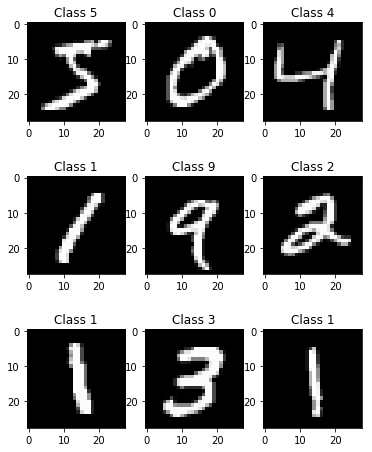

In [8]:
X_train =np.array([i[0].reshape(28, 28) for i in training_data])
y_train = np.array([np.argmax(i[1]) for i in training_data])

plt.figure('fig1', figsize=(6,8))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

In [12]:
net = Network([784, 30, 10])
net.SGD(training_data, 30, 10, 3.0, test_data=test_data)

Epoch 0: 8452 / 10000
Epoch 1: 8652 / 10000
Epoch 2: 8895 / 10000
Epoch 3: 9056 / 10000
Epoch 4: 8945 / 10000
Epoch 5: 8976 / 10000
Epoch 6: 9081 / 10000
Epoch 7: 9065 / 10000
Epoch 8: 8951 / 10000
Epoch 9: 9103 / 10000
Epoch 10: 9098 / 10000
Epoch 11: 8903 / 10000
Epoch 12: 9092 / 10000
Epoch 13: 9124 / 10000
Epoch 14: 9187 / 10000
Epoch 15: 9181 / 10000


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: RuntimeWarning: overflow encountered in exp


Epoch 16: 9145 / 10000
Epoch 17: 9103 / 10000
Epoch 18: 9034 / 10000
Epoch 19: 9148 / 10000
Epoch 20: 9086 / 10000
Epoch 21: 9170 / 10000
Epoch 22: 9220 / 10000
Epoch 23: 9241 / 10000
Epoch 24: 9153 / 10000
Epoch 25: 9243 / 10000
Epoch 26: 9239 / 10000
Epoch 27: 9282 / 10000
Epoch 28: 9249 / 10000
Epoch 29: 9296 / 10000


In [15]:
net = Network([784, 100, 10])
net.SGD(training_data, 50, 10, 5.0, test_data=test_data)

Epoch 0: 798 / 10000
Epoch 1: 968 / 10000
Epoch 2: 1216 / 10000
Epoch 3: 2372 / 10000
Epoch 4: 2160 / 10000
Epoch 5: 1758 / 10000
Epoch 6: 2215 / 10000
Epoch 7: 2651 / 10000
Epoch 8: 3303 / 10000
Epoch 9: 2938 / 10000
Epoch 10: 2776 / 10000
Epoch 11: 2521 / 10000
Epoch 12: 2987 / 10000
Epoch 13: 2921 / 10000


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: RuntimeWarning: overflow encountered in exp


Epoch 14: 3012 / 10000
Epoch 15: 3035 / 10000
Epoch 16: 3060 / 10000
Epoch 17: 2888 / 10000
Epoch 18: 3290 / 10000
Epoch 19: 3099 / 10000
Epoch 20: 3006 / 10000
Epoch 21: 3236 / 10000
Epoch 22: 3094 / 10000
Epoch 23: 2875 / 10000
Epoch 24: 3261 / 10000
Epoch 25: 3016 / 10000
Epoch 26: 3246 / 10000
Epoch 27: 3217 / 10000
Epoch 28: 3302 / 10000
Epoch 29: 3349 / 10000
Epoch 30: 3373 / 10000
Epoch 31: 3318 / 10000
Epoch 32: 3445 / 10000
Epoch 33: 3441 / 10000
Epoch 34: 3526 / 10000
Epoch 35: 3330 / 10000
Epoch 36: 3374 / 10000
Epoch 37: 3239 / 10000
Epoch 38: 3347 / 10000
Epoch 39: 3748 / 10000
Epoch 40: 3609 / 10000
Epoch 41: 3613 / 10000
Epoch 42: 3446 / 10000
Epoch 43: 3661 / 10000
Epoch 44: 3760 / 10000
Epoch 45: 3506 / 10000
Epoch 46: 3477 / 10000
Epoch 47: 3345 / 10000
Epoch 48: 3436 / 10000
Epoch 49: 3221 / 10000
